# A Binary Classification Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

## Simulate Raw Data; Split Train/Dev/Test

In [16]:
# draw data from two independent Gaussian distributions: 0 = mean (0,0); 1 = mean(1,1); var = 0.1
N = 1000
group0 = np.random.multivariate_normal(mean = [0., 0.], cov = [[0.1, 0.], [0., 0.1]], size=N)
group1 = np.random.multivariate_normal(mean = [1., 1.], cov = [[0.1, 0.], [0., 0.1]], size=N)
group0_label, group1_label = np.zeros(N), np.ones(N)
# shuffle data
X, Y = np.append(group0,group1,axis=0), np.append(group0_label,group1_label,axis=0)
L = len(X)
indices = list(range(L))
np.random.shuffle(indices)
# split train/dev/test
train_indices, dev_indices, test_indices = indices[:int(0.8*L)], indices[int(0.8*L):int(0.9*L)], indices[int(0.9*L):]
Xtrain, Xdev, Xtest = X[train_indices], X[dev_indices], X[test_indices]
Ytrain, Ydev, Ytest = Y[train_indices], Y[dev_indices], Y[test_indices]

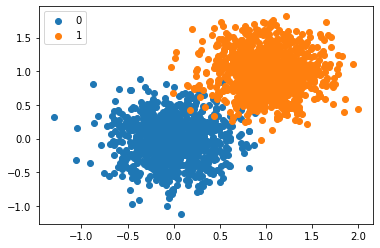

In [17]:
# Let's take a lot at the generated data
plt.figure()
plt.scatter(x=group0.T[0], y=group0.T[1], label=0)
plt.scatter(x=group1.T[0], y=group1.T[1], label=1)
plt.legend()

## Convert to Tensors and Split into batches

In [18]:
# organize data into torch dataloaders
# train
train_set = TensorDataset(torch.tensor(Xtrain), torch.tensor(Ytrain))
train_loader = DataLoader(train_set, batch_size=128)
# dev 
dev_set = TensorDataset(torch.tensor(Xdev), torch.tensor(Ydev))
dev_loader = DataLoader(dev_set, batch_size=128)
# test
test_set = TensorDataset(torch.tensor(Xtest), torch.tensor(Ytest))
test_loader = DataLoader(test_set, batch_size=128)
# show sizes
len(train_set), len(dev_set), len(test_set)

(1600, 200, 200)

## Define Neural Network and Classification Method

In [19]:
class MLP(nn.Module):
    # a simple 2-layer neural net implemented from scratch
    
    def __init__(self, input_dim = 2, output_dim=2, n_neurons = 16, activation=nn.Sigmoid):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_neurons = n_neurons
        self.h1=nn.Linear(input_dim, n_neurons)
        self.h2=nn.Linear(n_neurons, n_neurons)
        self.output=nn.Linear(n_neurons, output_dim)
        self.activation=activation()
    
    def forward(self, x):
        x=self.activation(self.h1(x.float()))
        x=self.activation(self.h2(x))
        x=self.output(x)
        return x      

In [20]:
# Code Reference: https://www.kaggle.com/basu369victor/pytorch-tutorial-the-classification

class Classifier():
    
    def __init__(self, model, criterion=nn.CrossEntropyLoss, optimizer=optim.Adam):
        self.model = model
        self.criterion = criterion()
        self.optimizer = optimizer(self.model.parameters())
    
    def train(self, train_loader, dev_loader=None, n_epochs=10):
        # set to train mode
        self.model.train()
        for epoch in range(n_epochs):
            for feature, target in train_loader:
                # compute loss and back-prop
                self.optimizer.zero_grad()
                output = self.model(feature)                
                loss = self.criterion(output, target.long())
                loss.backward()
                self.optimizer.step()
            # check dev accuracy
            if dev_loader != None:
                acc = self.validate(dev_loader)
                print(f"{acc*100.0:.2f}% : dev acc of epoch-{epoch}")

    def validate(self, data_loader):
        self.model.eval()
        correct = 0.
        total = 0.
        with torch.no_grad():
            for feature, target in data_loader:
                output = self.model(feature)
                _, prediction = torch.max(output, dim=1)
                correct += torch.sum(prediction==target).item()
                total += target.size(0)
        return 1.0 * correct / total
        
    def test(self, data_loader): 
        acc = self.validate(data_loader)
        print(f"{acc*100.0:.2f}% : test acc")

## Train and Test

In [23]:
mymodel = MLP()
myclassifier = Classifier(mymodel)
myclassifier.train(train_loader, dev_loader)

46.00% : dev acc of epoch-0
46.00% : dev acc of epoch-1
80.00% : dev acc of epoch-2
95.00% : dev acc of epoch-3
97.50% : dev acc of epoch-4
97.50% : dev acc of epoch-5
98.50% : dev acc of epoch-6
99.00% : dev acc of epoch-7
98.50% : dev acc of epoch-8
98.50% : dev acc of epoch-9


In [24]:
myclassifier.test(test_loader)

99.50% : test acc
